In [29]:
import numpy as np
import gurobipy as gp
from gurobipy import GRB

import matplotlib.pyplot as plt
import numpy as np

from sklearn import datasets
from sklearn import model_selection
from sklearn.datasets import make_circles
import plotly.graph_objects as go
from numba import njit

import neal

from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    average_precision_score,
    roc_curve,
    precision_recall_curve,
    auc
)

데이터 및 상수 생성

In [30]:
# iris = datasets.load_iris()
# # iris data 불러오기
# X_train, X_test, y_train, y_test = model_selection.train_test_split(iris.data[:100, :2], iris.target[:100], test_size = 0.9, random_state = 40)
# #test_size: iris.data와 iris.target의 데이터 중 60%를 X_test와 y_test에 분배, 나머지 40%를 X_train과 y_train에 분배
# #random_state: iris.data, iris.target의 데이터를 랜덤으로 믹스
# # 즉, 데이터를 랜덤하게 섞은 후 test_size = 0.6에 맞춰서 분배

# y_train = 2 * y_train - 1
# y_test = 2 * y_test - 1

In [31]:
n_train = 50

X, Y = make_circles(n_samples = 200, noise=0.1, random_state = 40)
X_train = X[:n_train, :]
X_test = X[n_train:, :]
y_train = Y[:n_train] 
y_test = Y[n_train:]
                                
y_train = 2 * y_train - 1
y_test = 2 * y_test - 1

In [32]:
N_train = X_train.shape[0]

Q metric 생성

In [33]:
@njit
def Gaussian_kernel(n, m, gamma, X_1, X_2):
    P = np.exp(-1 * gamma * ((X_1[n, :] - X_2[m, :]) @ (X_1[n, :] - X_2[m, :])))

    return(P)

In [34]:
def Q_metric():
    Q = np.zeros((K*N_train,K*N_train))

    K_train_train = np.zeros((N_train, N_train))
    for n in range(N_train):
        for m in range(N_train):
            K_train_train[n, m] = Gaussian_kernel(n, m, gamma,  X_train, X_train)

    for n in range(N_train):
        for m in range(N_train):
            for k in range(K):
                for j in range(K):  
                    Q[K*n + k, K*m + j] = 0.5 * (B**(k+j)) * y_train[n] * y_train[m] * (Gaussian_kernel(n, m, gamma, X_train, X_train) + xi)

                    if n == m and k == j:
                        Q[K*n + k, K*m + j] += -B**k

    return K_train_train, Q

Solver 구하기

In [35]:
def neal_Solver(Q):

    sampler = neal.SimulatedAnnealingSampler()

    sampleset = sampler.sample_qubo(
        Q,
        num_reads=10000,
        beta_range=(0.1, 30),
        num_sweeps=1000
    )

    top_solutions = sampleset.lowest(20)

    return top_solutions

학습

In [36]:
def Solution(sol, top_k, n_th):
    solutions = []

    # SampleSet에서 sample, energy를 전부 꺼냄
    for rec in sol.data(['sample', 'energy']):
        solutions.append((rec.sample, rec.energy))  # (dict, float)

    # energy 기준 오름차순 정렬 (버전 독립)
    solutions_sorted = sorted(solutions, key=lambda t: t[1])

    # top_k 중 n_th번째 선택
    sample = solutions_sorted[n_th][0]
    energy = solutions_sorted[n_th][1]

    # x_opt 벡터 구성 (변수 인덱스 순서 고정)
    keys = sorted(sample.keys())
    x_opt = np.array([sample[k] for k in keys], dtype=int)

    return x_opt, energy

In [37]:
def alpha_value(x_opt):

    X_matrix = x_opt.reshape(-1, K)
    print(X_matrix)
    alpha = np.zeros(N_train)


    for n in range(N_train):
        a = 0
        
        for k in range(K):
            a = a + (B**k) * X_matrix[n][k]

        alpha[n] = a

    return alpha

In [38]:
@njit
def Gaussian_Parameter(i, gamma, z, X_train):
    # z: (2,), X_train: (N,2)
    diff = X_train[i, :] - z
    return np.exp(-gamma * (diff @ diff))

In [39]:
@njit
def Gaussian_HyperPlane(xx, yy, X_train, y_train, alpha, gamma, b):
    # 타입/shape 안정화 (매우 중요)
    X_train = np.asarray(X_train, dtype=np.float64)
    y_train = np.asarray(y_train, dtype=np.float64).ravel()
    alpha   = np.asarray(alpha,   dtype=np.float64).ravel()
    HP = np.where((alpha > 0) & (alpha < C))[0]
    gamma   = float(gamma)
    b       = float(b)

    N = X_train.shape[0]
    Z = np.zeros(xx.shape, dtype=np.float64)

    for r in range(xx.shape[0]):
        for c in range(xx.shape[1]):
            z = np.array([xx[r, c], yy[r, c]], dtype=np.float64)

            s = 0.0
            for i in HP:
                s += Gaussian_Parameter(i, gamma, z, X_train) * alpha[i] * y_train[i]

            Z[r, c] = s + b   # b는 한 번만 더함

    return Z


In [40]:
def b_value(alpha, y, K):
    alpha = np.asarray(alpha, dtype=float).ravel()
    y = np.asarray(y, dtype=float).ravel()
    K = np.asarray(K, dtype=float)

    HP = np.where((alpha > 0) & (alpha < C))[0]

    g = (alpha * y) @ K

    b = np.mean(y[HP] - g[HP])

    return b

In [41]:
def Train_Graph(alpha, energy): 

# 2-D graph############################################################################################################
    h = 0.01
    x_min, x_max = X_train[:, 0].min()-1, X_train[:, 0].max()+1
    y_min, y_max = X_train[:, 1].min()-1, X_train[:, 1].max()+1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h))

    # b를 모르면 일단 0으로 두고 경계 모양을 먼저 확인 가능
    b = b_value(alpha, y_train, Q_metric()[0])
    
    Z = Gaussian_HyperPlane(xx, yy, X_train, y_train, alpha, gamma, b)

    plt.contourf(xx, yy, Z,
                levels=[Z.min(), 0, Z.max()],
                colors=['#87CEEB', '#8B4513'],
                alpha=0.5)

    plt.contour(xx, yy, Z, levels=[0], colors='k', linewidths=2)  # 결정경계 강조

    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.Paired)

    plt.title(f'Quantum Gaussian SVM train energy={energy:.2f}')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.show()
#######################################################################################################################

# 3-D graph############################################################################################################
    # fig = go.Figure()

    # fig.add_trace(
    #     go.Surface(
    #         x=xx,
    #         y=yy,
    #         z=Z,
    #         colorscale='RdBu',
    #         opacity=0.85,
    #         colorbar=dict(title='f(x, y)')
    #     )
    # )


    # fig.update_layout(
    #     title='RBF (Gaussian) qSVM Decision Surface',
    #     scene=dict(
    #         xaxis_title='Sepal Length',
    #         yaxis_title='Sepal Width',
    #         zaxis_title='Decision value f(x,y)'
    # ))


    # fig.show()
#######################################################################################################################

X_test Data

In [42]:
def Test_evlauation(alpha, K_train_train):

    N_train = X_train.shape[0]
    N_test = X_test.shape[0]

    K_train_test = np.zeros((N_train, N_test))

    for n in range(N_train):
        for m in range(N_test):
            K_train_test[n, m] = Gaussian_kernel(n, m, gamma, X_train, X_test)

    scores_test = (alpha * y_train) @ K_train_test + b_value(alpha, y_train, K_train_train)

    return scores_test

In [43]:
def Test_Graph(alpha, K_train_train, energy):

# 2-D graph############################################################################################################
    h = 0.01

    x_min, x_max = X_test[:, 0].min()-1 , X_test[:, 0].max() + 1
    y_min, y_max = X_test[:, 1].min()-1 , X_test[:, 1].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    grid = np.c_[xx.ravel(), yy.ravel()]  # (N_grid, 2)

    # grid에 대한 decision score f(x) 계산: f(x) = Σ α_i y_i k(x_i, x) + b
    N_train = X_train.shape[0]
    N_grid = grid.shape[0]

    K_train_grid = np.zeros((N_train, N_grid))
    for i in range(N_train):
        for j in range(N_grid):
            K_train_grid[i, j] = Gaussian_kernel(i, j, gamma, X_train, grid)

    scores_grid = (alpha * y_train) @ K_train_grid + b_value(alpha, y_train, K_train_train)
    Z = scores_grid.reshape(xx.shape)

    plt.contourf(xx, yy, Z, levels=[Z.min(), 0, Z.max()], colors=['#87CEEB', '#8B4513'], alpha=0.5)
    plt.contour(xx, yy, Z, levels=[0], colors='k', linewidths=2)
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.Paired)

    plt.title(f'Quantum Gaussian SVM test energy={energy:.2f}')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.show()
#######################################################################################################################

# 3-D graph############################################################################################################
    # fig = go.Figure()

    # fig.add_trace(
    #     go.Surface(
    #         x=xx,
    #         y=yy,
    #         z=Z,
    #         colorscale='RdBu',
    #         opacity=0.85,
    #         colorbar=dict(title='f(x, y)')
    #     )
    # )


    # fig.update_layout(
    #     title='RBF (Gaussian) qSVM Decision Surface',
    #     scene=dict(
    #         xaxis_title='Sepal Length',
    #         yaxis_title='Sepal Width',
    #         zaxis_title='Decision value f(x,y)'
    # ))


    # fig.show()
#######################################################################################################################

평가


In [44]:
def evaluate_train(y_true, alpha, K_train_train, threshold=0.0):
    y_true = np.asarray(y_true)
    scores_train = (alpha * y_train) @ K_train_train + b_value(alpha, y_train, K_train_train)
    scores_train = np.asarray(scores_train, dtype=float)

    # print(b_value(alpha, y_train, K_train_train))

    if set(np.unique(y_true)) == {-1, 1}:
        y_true_bin = (y_true == 1).astype(int)
    else:
        y_true_bin = y_true.astype(int)

    # Accuracy (threshold 기반)
    y_pred = (scores_train >= threshold).astype(int)
    accuracy = accuracy_score(y_true_bin, y_pred)

    # AUROC / AUPRC (threshold-independent)
    auroc = roc_auc_score(y_true_bin, scores_train)
    auprc = average_precision_score(y_true_bin, scores_train)

    return accuracy, auroc, auprc, scores_train

In [45]:
def evaluate_test(y_true, decision_scores, threshold=0.0):
    y_true = np.asarray(y_true)
    decision_scores = np.asarray(decision_scores)

    # {-1, +1} → {0, 1}
    if set(np.unique(y_true)) == {-1, 1}:
        y_true_bin = (y_true == 1).astype(int)
    else:
        y_true_bin = y_true.astype(int)

    # Accuracy (threshold 기반)
    y_pred = (decision_scores >= threshold).astype(int)
    accuracy = accuracy_score(y_true_bin, y_pred)

    # AUROC / AUPRC (threshold-independent)
    auroc = roc_auc_score(y_true_bin, decision_scores)
    auprc = average_precision_score(y_true_bin, decision_scores)

    return accuracy, auroc, auprc


In [46]:
def Evaluate(alpha, K_train_train):
    acc, auroc, auprc = evaluate_test(
        y_test,
        Test_evlauation(alpha, K_train_train)
    )

    print(f"Test Accuracy : {acc:.4f}")
    print(f"Test AUROC    : {auroc:.4f}")
    print(f"Test AUPRC    : {auprc:.4f}")

    y_true = np.asarray(y_test).ravel()
    if set(np.unique(y_true)) == {-1, 1}:
        y_true = (y_true == 1).astype(int)

    scores = np.asarray(Test_evlauation(alpha, K_train_train)).ravel()

    # ROC 계산
    fpr, tpr, thresholds = roc_curve(y_true, scores)
    roc_auc = auc(fpr, tpr)

    # Plot
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (SVM)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()


Overfitting

In [47]:
def Evaluate_Overfitting(acc_train, acc_test, auroc_train, auroc_test, auprc_train, auprc_test):

    gap_acc   = acc_train   - acc_test
    gap_auroc = auroc_train - auroc_test
    gap_auprc = auprc_train - auprc_test
    
    return gap_acc, gap_auroc, gap_auprc

In [48]:
def Hinge_Loss(alpha, K_train_train, scores_train):
    scores_test = Test_evlauation(alpha, K_train_train)

    loss_train = np.maximum(0, 1 - (y_train * scores_train))
    loss_test = np.maximum(0, 1 - (y_test * scores_test))

    loss_train_mean = np.mean(loss_train)
    loss_test_mean  = np.mean(loss_test)

    return loss_train_mean, loss_test_mean

In [49]:
def Lagrangian(alpha, K_train_train, energy):

    lagrangian_w = ( 0.5 * ((alpha * y_train) @ K_train_train @ (alpha * y_train)) - sum(alpha) )

    lagrangian_b = -1 * sum(alpha * y_train * b_value(alpha, y_train, K_train_train))

    lagrangian_xi = energy - lagrangian_w - lagrangian_b

    return lagrangian_w, lagrangian_b, lagrangian_xi

In [50]:
def Primal(alpha, K_train_train):
    J_w =  0.5 * ((alpha * y_train) @ K_train_train @ (alpha * y_train))
    scores = (alpha * y_train) @ K_train_train + b_value(alpha, y_train, K_train_train)

    # slack
    xi = np.maximum(0, 1 - y_train * scores)

    # sum xi
    J_xi = np.sum(xi)

    return J_w, J_xi

코드 조작

In [ ]:
B = 5
K = 3
xi = 1
gamma = 2.9
C = 0
for k in range(K):
    C += B**k

# acc_list = []
# auroc_list = []
# auprc_list = []

gap_acc_list = []
gap_auroc_list = []
gap_auprc_list = []

Loss_train_mean = []
Loss_test_mean = []

lagrangian_w_list =[] 
lagrangian_b_list = []
lagrangian_xi_list = []

J_w_list=[]
J_xi_list = []

E = []

top_k = 20
n_th = 0

K_train_train, Q = Q_metric()
Q = np.triu(Q + Q.T - np.diag(np.diag(Q)))
sol = neal_Solver(Q)

for n_th in range(top_k):

    x_opt, energy = Solution(sol, top_k, n_th)

    E.append(energy)

    alpha = alpha_value(x_opt)

    acc_train, auroc_train, auprc_train, scores_train = evaluate_train(
            y_train,
            alpha,
            K_train_train,
        )

    acc_test, auroc_test, auprc_test = evaluate_test(
            y_test,
            Test_evlauation(alpha, K_train_train)
        )
    
    # Train_Graph(alpha, energy)

    # Test_Graph(alpha, K_train_train, energy)

    gap_acc, gap_auroc, gap_auprc = Evaluate_Overfitting(acc_train, acc_test, auroc_train, auroc_test, auprc_train, auprc_test)

    lagrangian_w, lagrangian_b, lagrangian_xi = Lagrangian(alpha, K_train_train, energy)
    lagrangian_w_list.append(lagrangian_w)
    lagrangian_b_list.append(lagrangian_b)
    lagrangian_xi_list.append(lagrangian_xi)

    print("#" * 25)
    print(f"lagrangian_w : {lagrangian_w:.4f}")
    print(f"lagrangian_b    : {lagrangian_b:.4f}")
    print(f"lagrangian_xi    : {lagrangian_xi:.4f}")
    print("#" * 25)

    gap_acc_list.append(gap_acc)
    gap_auroc_list.append(gap_auroc)
    gap_auprc_list.append(gap_auprc)
    
    Loss_train, Loss_test= Hinge_Loss(alpha, K_train_train, scores_train)

    Loss_train_mean.append(Loss_train)
    Loss_test_mean.append(Loss_test)

    J_w, J_xi = Primal(alpha, K_train_train)
    J_w_list.append(J_w)
    J_xi_list.append(J_xi)

print(E)

[[1 0 0]
 [1 0 0]
 [1 1 1]
 [0 0 0]
 [0 1 1]
 [0 0 1]
 [0 0 1]
 [1 1 1]
 [1 1 0]
 [1 1 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [1 1 0]
 [0 0 0]
 [1 1 0]
 [0 0 0]
 [0 0 0]
 [1 1 0]
 [1 1 1]
 [0 0 0]
 [1 1 1]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 1]
 [0 0 0]
 [0 0 0]
 [1 1 1]
 [0 0 1]
 [1 1 1]
 [0 0 0]
 [1 0 1]
 [1 0 0]
 [0 0 0]
 [0 1 0]
 [0 0 0]
 [0 0 0]
 [0 0 1]
 [0 0 0]
 [0 1 0]
 [1 1 1]
 [1 1 0]
 [1 1 0]
 [1 1 1]
 [0 0 0]
 [1 1 0]
 [0 1 0]
 [0 0 1]]
#########################
lagrangian_w : -313.8719
lagrangian_b    : -3.2521
lagrangian_xi    : 5.2521
#########################
[[1 0 0]
 [0 0 0]
 [1 1 1]
 [0 0 0]
 [0 1 1]
 [1 1 0]
 [0 1 1]
 [1 1 1]
 [1 1 0]
 [1 1 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 1 0]
 [0 0 0]
 [0 1 1]
 [0 0 0]
 [0 0 0]
 [1 1 0]
 [1 1 1]
 [0 0 0]
 [1 1 1]
 [0 1 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 1]
 [0 0 0]
 [0 0 0]
 [1 1 1]
 [0 0 1]
 [1 0 0]
 [0 0 0]
 [1 0 1]
 [1 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [1 1 0]
 [0 0 0]
 [0 1 0]
 [0 0 1]
 [1 0 0]
 [0 0 1]
 [1 1 1]
 [0 0 

20


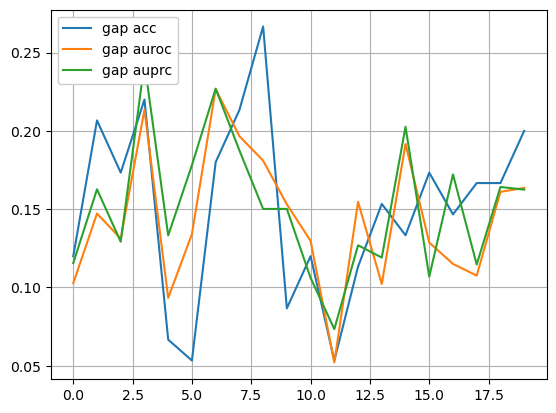

In [52]:
x = [x for x in range(20)]
print(len(x))
plt.plot(x, gap_acc_list, label = "gap acc")
plt.plot(x, gap_auroc_list, label = "gap auroc")
plt.plot(x, gap_auprc_list, label = "gap auprc")

# plt.plot(x, lagrangian_spe_list, label = "lagrangian_spe")
# plt.plot(E, lagrangian_sv_list, label = "lagrangian_sv")

# plt.ylim(0, 1)
# plt.xticks(np.arange(0, 20, 1))
# plt.xlim(0, 20)

# plt.yscale('log')

plt.legend(loc = 'upper left', framealpha = 1)
plt.grid()
plt.show()

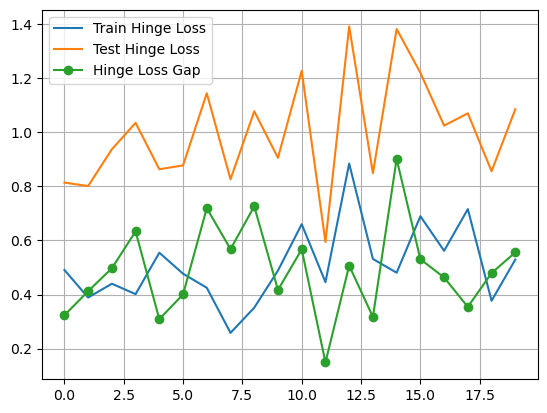

In [53]:
Loss = [(Loss_test_mean[i] - Loss_train_mean[i]) for i in range(len(Loss_train_mean))]

plt.plot(x, Loss_train_mean, label = "Train Hinge Loss")
plt.plot(x, Loss_test_mean, label = "Test Hinge Loss")
plt.plot(x, Loss, 'o-', label = "Hinge Loss Gap")
# plt.plot(x, lagrangian_spe_list, '^-', label = "lagrangian_spe")
# plt.plot(E, lagrangian_sv_list, label = "lagrangian_sv")
# plt.yscale('log')
plt.grid()
plt.legend()
plt.show()

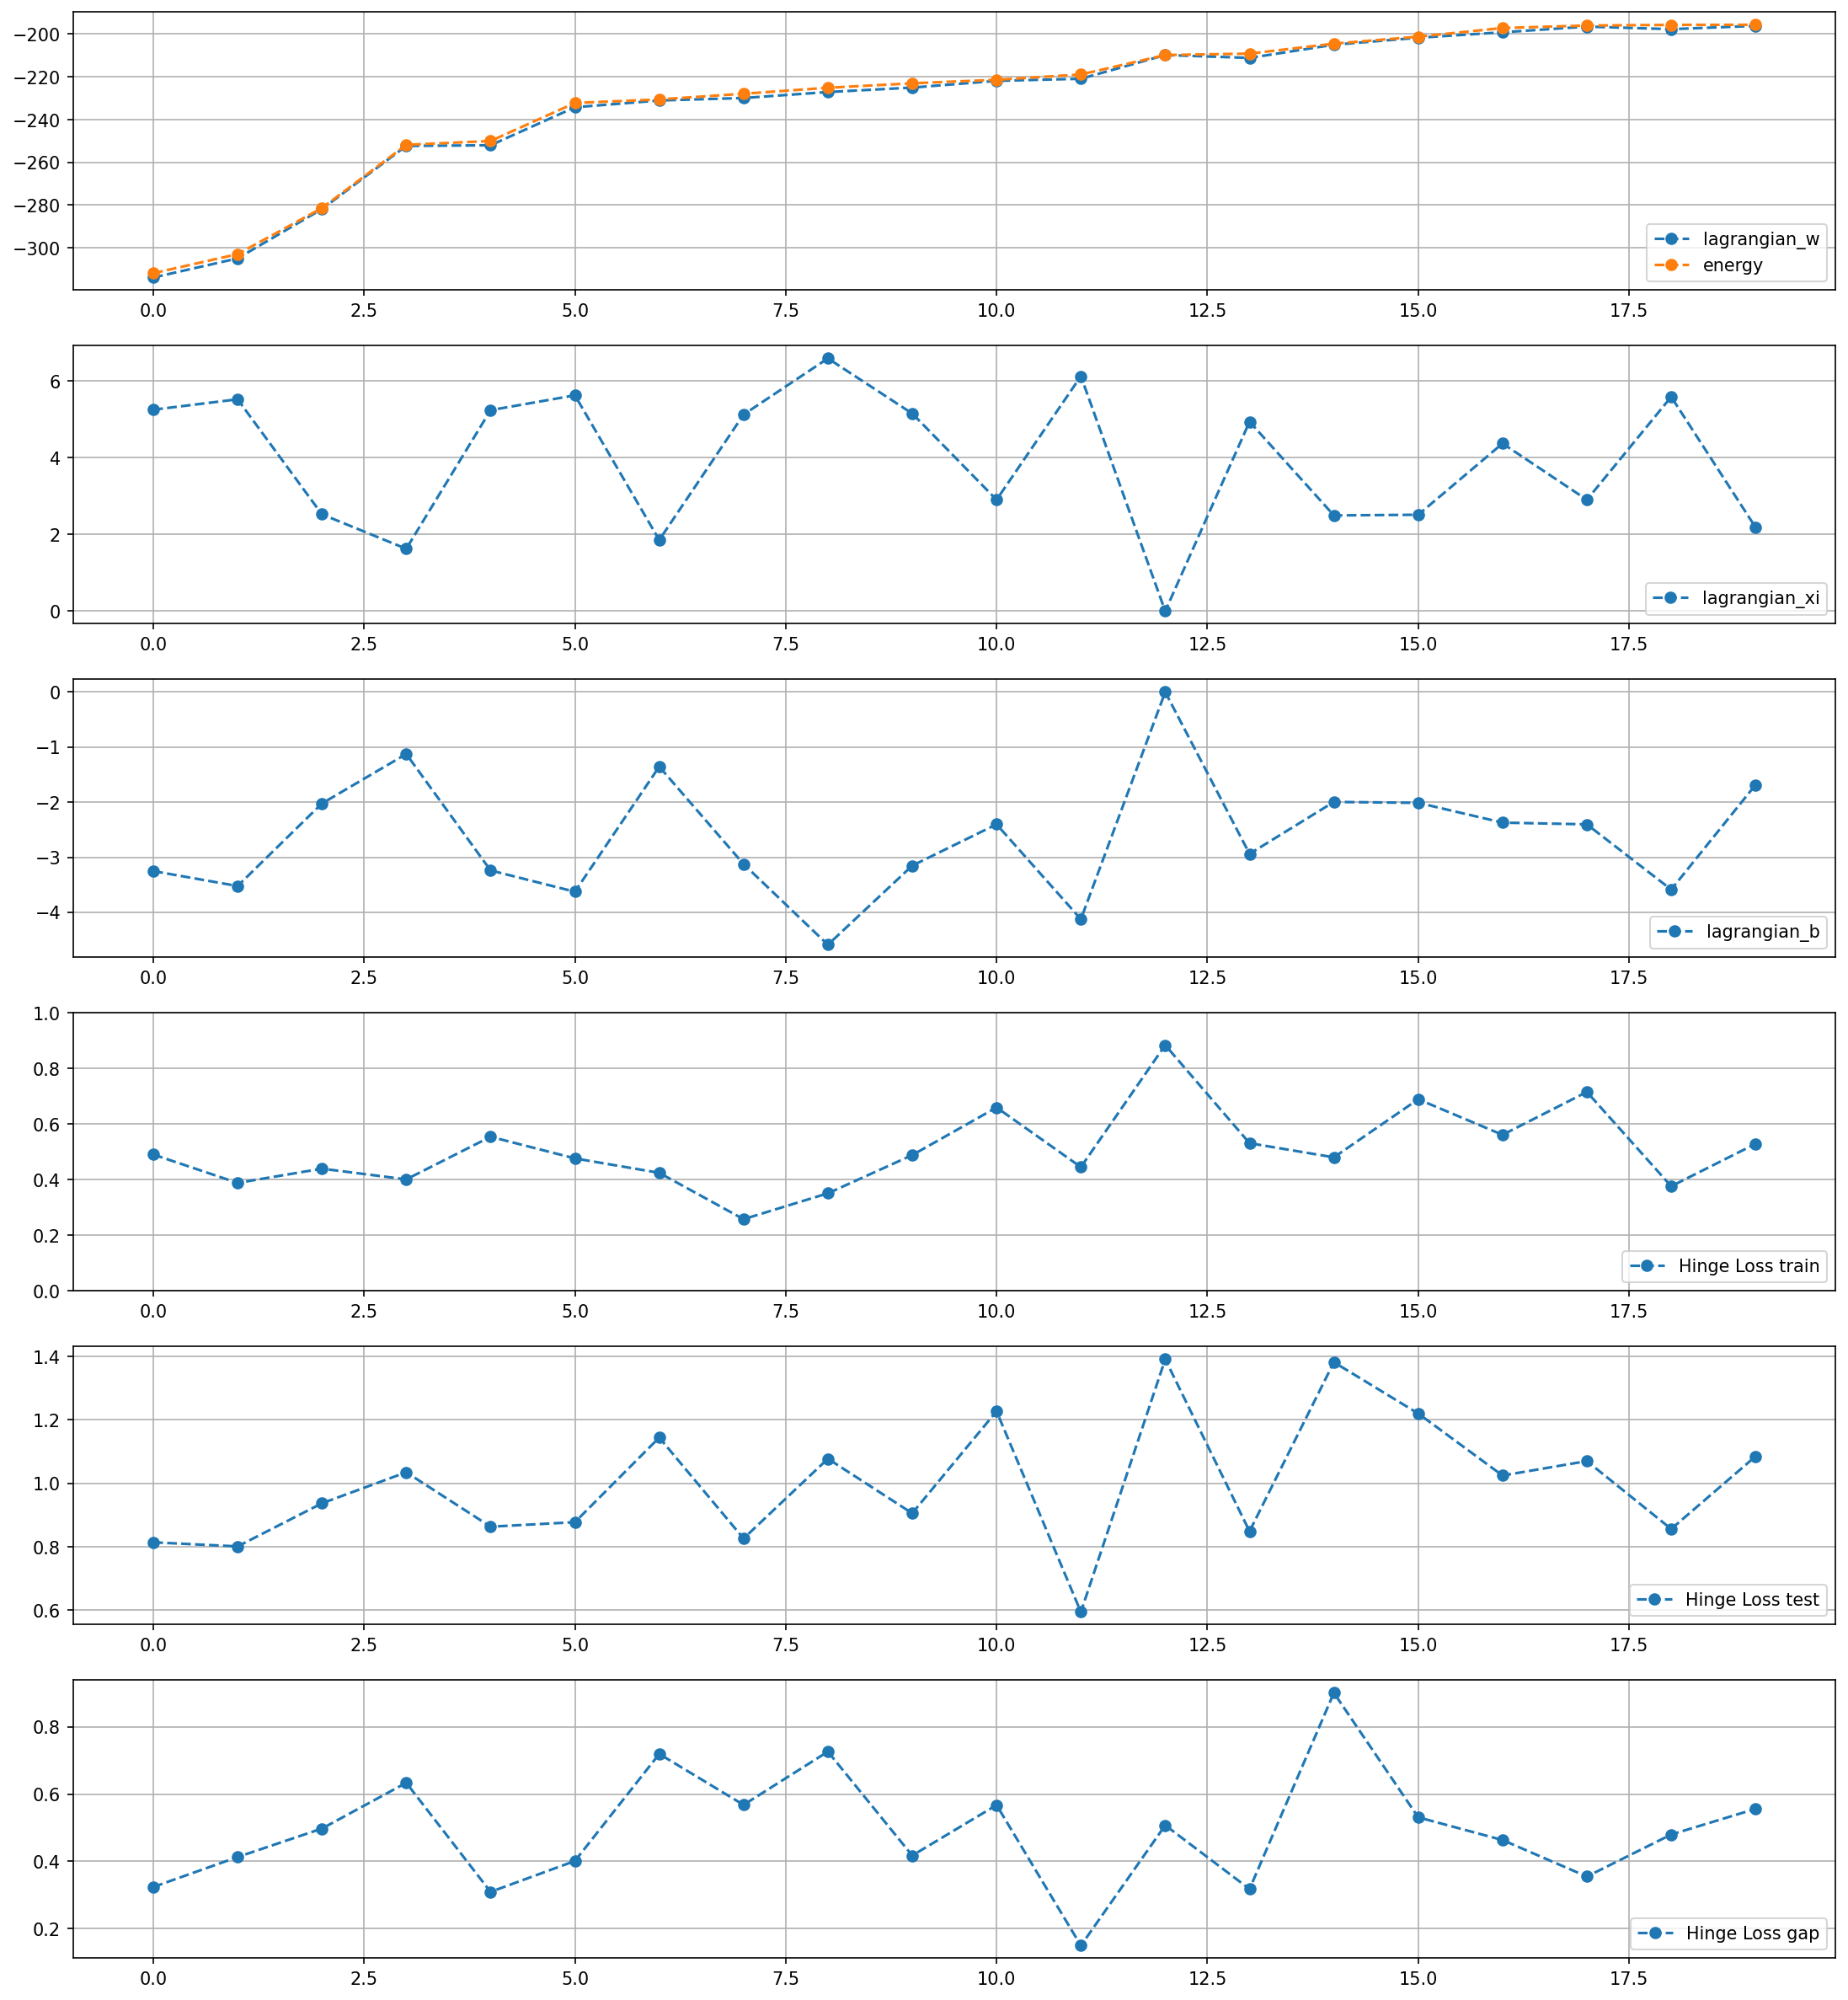

In [54]:
fig, axes = plt.subplots(
    6, 1,
    figsize=(18, 20),   # 전체 크기 고정
    dpi=150,
    sharex=False
)

# lagrangian_spe_plus_list = [(E[x] * lagrangian_x_list[x]) for x in range(len(lagrangian_spe_list))]
# lagrangian_sv_plus_list = [(E[x] * lagrangian_sv_list[x]) for x in range(len(lagrangian_spe_list))]
# axes[0].plot(E, E, "^--", label = "energy")

axes[0].plot(x, lagrangian_w_list, "o--", label = "lagrangian_w")
axes[0].plot(x, E, "o--", label = "energy")
# axes[0].plot(x, lagrangian_w_list - E)
# axes[0].set_ylim(1, 1.1)
# axes[0].set_yscale('log')
axes[0].grid()
axes[0].legend(loc = "lower right")

axes[1].plot(x, lagrangian_xi_list, "o--", label = "lagrangian_xi")
# axes[1].set_ylim(0, 0.1)
# axes[1].set_yscale('log')
axes[1].grid()
axes[1].legend(loc = "lower right")

axes[2].plot(x, lagrangian_b_list, "o--", label = "lagrangian_b")
# axes[0].set_ylim(1, 1.1)
# axes[0].set_yscale('log')
axes[2].grid()
axes[2].legend(loc = "lower right")

axes[3].plot(x, Loss_train_mean, 'o--', label = "Hinge Loss train")
axes[3].set_ylim(0, 1)
axes[3].grid()
axes[3].legend(loc = "lower right")

axes[4].plot(x, Loss_test_mean, "o--", label = "Hinge Loss test")
# axes[1].set_ylim(0, 0.1)
# axes[1].set_yscale('log')
# axes[4].set_ylim(0, 1)
axes[4].grid()
axes[4].legend(loc = "lower right")

axes[5].plot(x, Loss, "o--", label = "Hinge Loss gap")
# axes[1].set_ylim(0, 0.1)
# axes[1].set_yscale('log')
# axes[5].set_ylim(0, 1)
axes[5].grid()
axes[5].legend(loc = "lower right")



# plt.show()

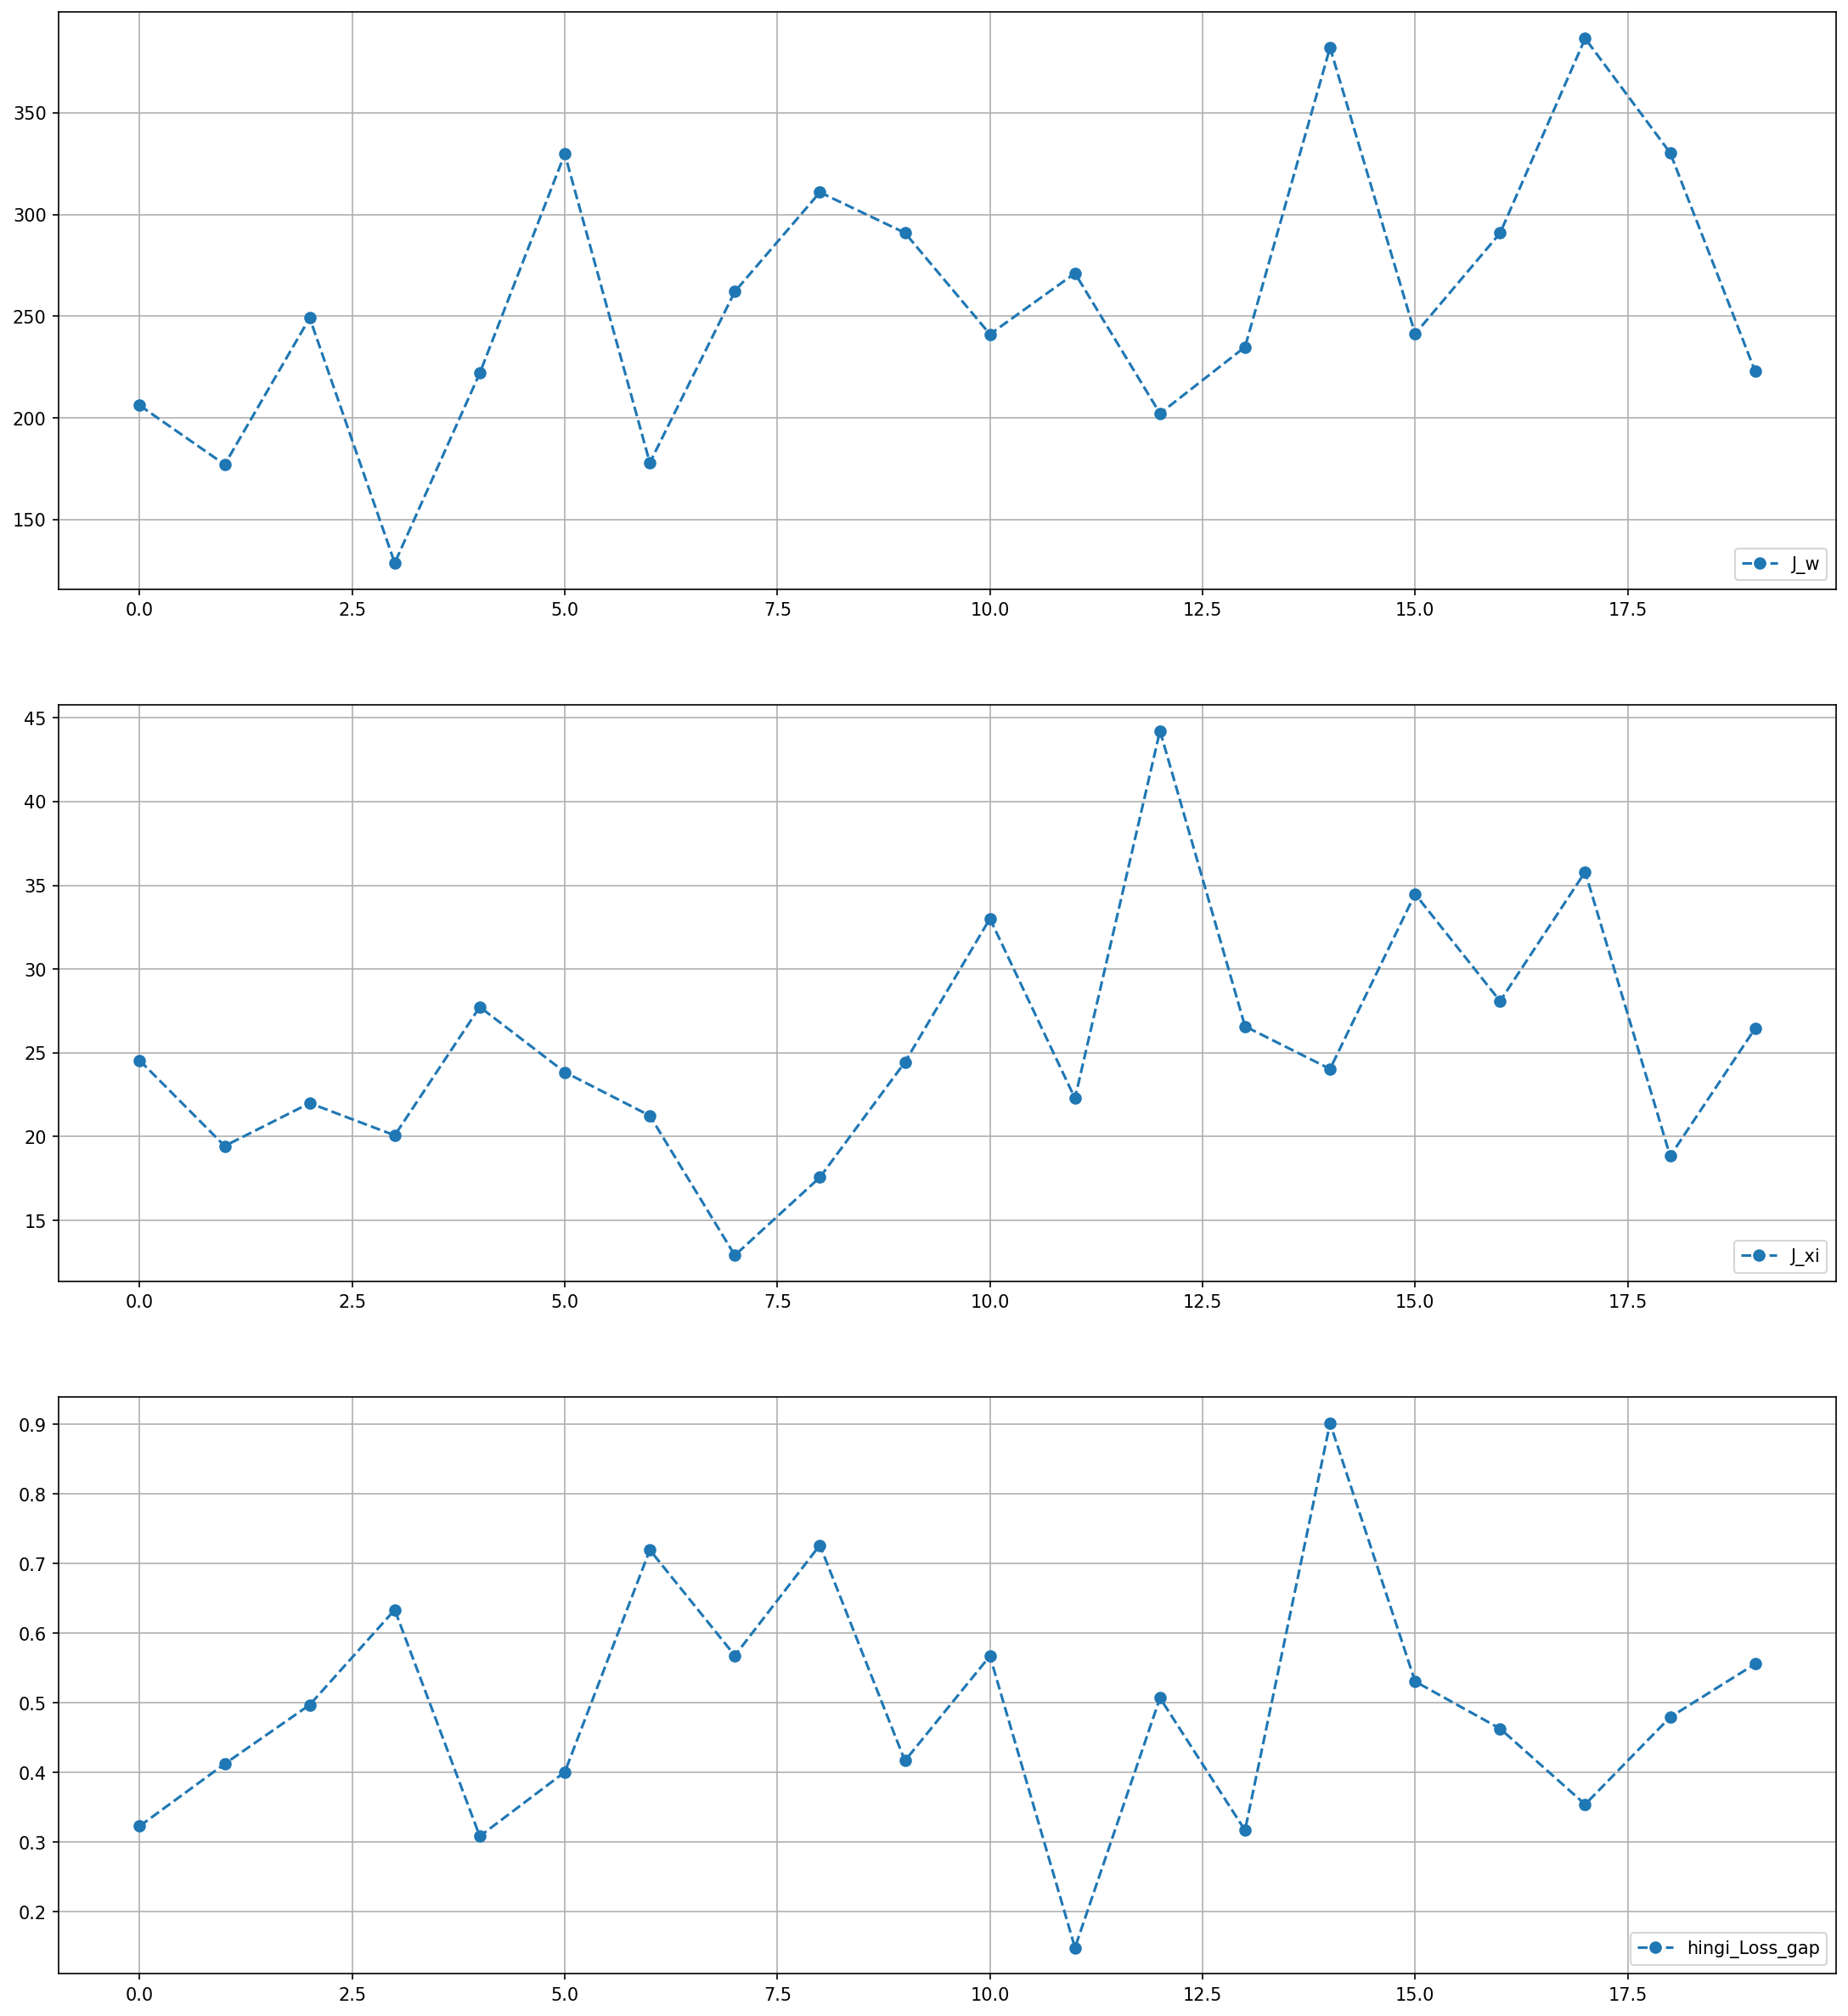

In [55]:
fig, axes = plt.subplots(
    3, 1,
    figsize=(18, 20),   # 전체 크기 고정
    dpi=150,
    sharex=False
)

# lagrangian_spe_plus_list = [(E[x] * lagrangian_x_list[x]) for x in range(len(lagrangian_spe_list))]
# lagrangian_sv_plus_list = [(E[x] * lagrangian_sv_list[x]) for x in range(len(lagrangian_spe_list))]
# axes[0].plot(E, E, "^--", label = "energy")

axes[0].plot(x, J_w_list, "o--", label = "J_w")
# axes[0].plot(x, E, "o--", label = "energy")
# axes[0].plot(x, lagrangian_w_list - E)
# axes[0].set_ylim(1, 1.1)
# axes[0].set_yscale('log')
axes[0].grid()
axes[0].legend(loc = "lower right")

axes[1].plot(x, J_xi_list, "o--", label = "J_xi")
# axes[1].set_ylim(0, 0.1)
# axes[1].set_yscale('log')
axes[1].grid()
axes[1].legend(loc = "lower right")

axes[2].plot(x, Loss, "o--", label = "hingi_Loss_gap")
# axes[0].set_ylim(1, 1.1)
# axes[0].set_yscale('log')
axes[2].grid()
axes[2].legend(loc = "lower right")

NameError: name 'lagrangian_spe_list' is not defined

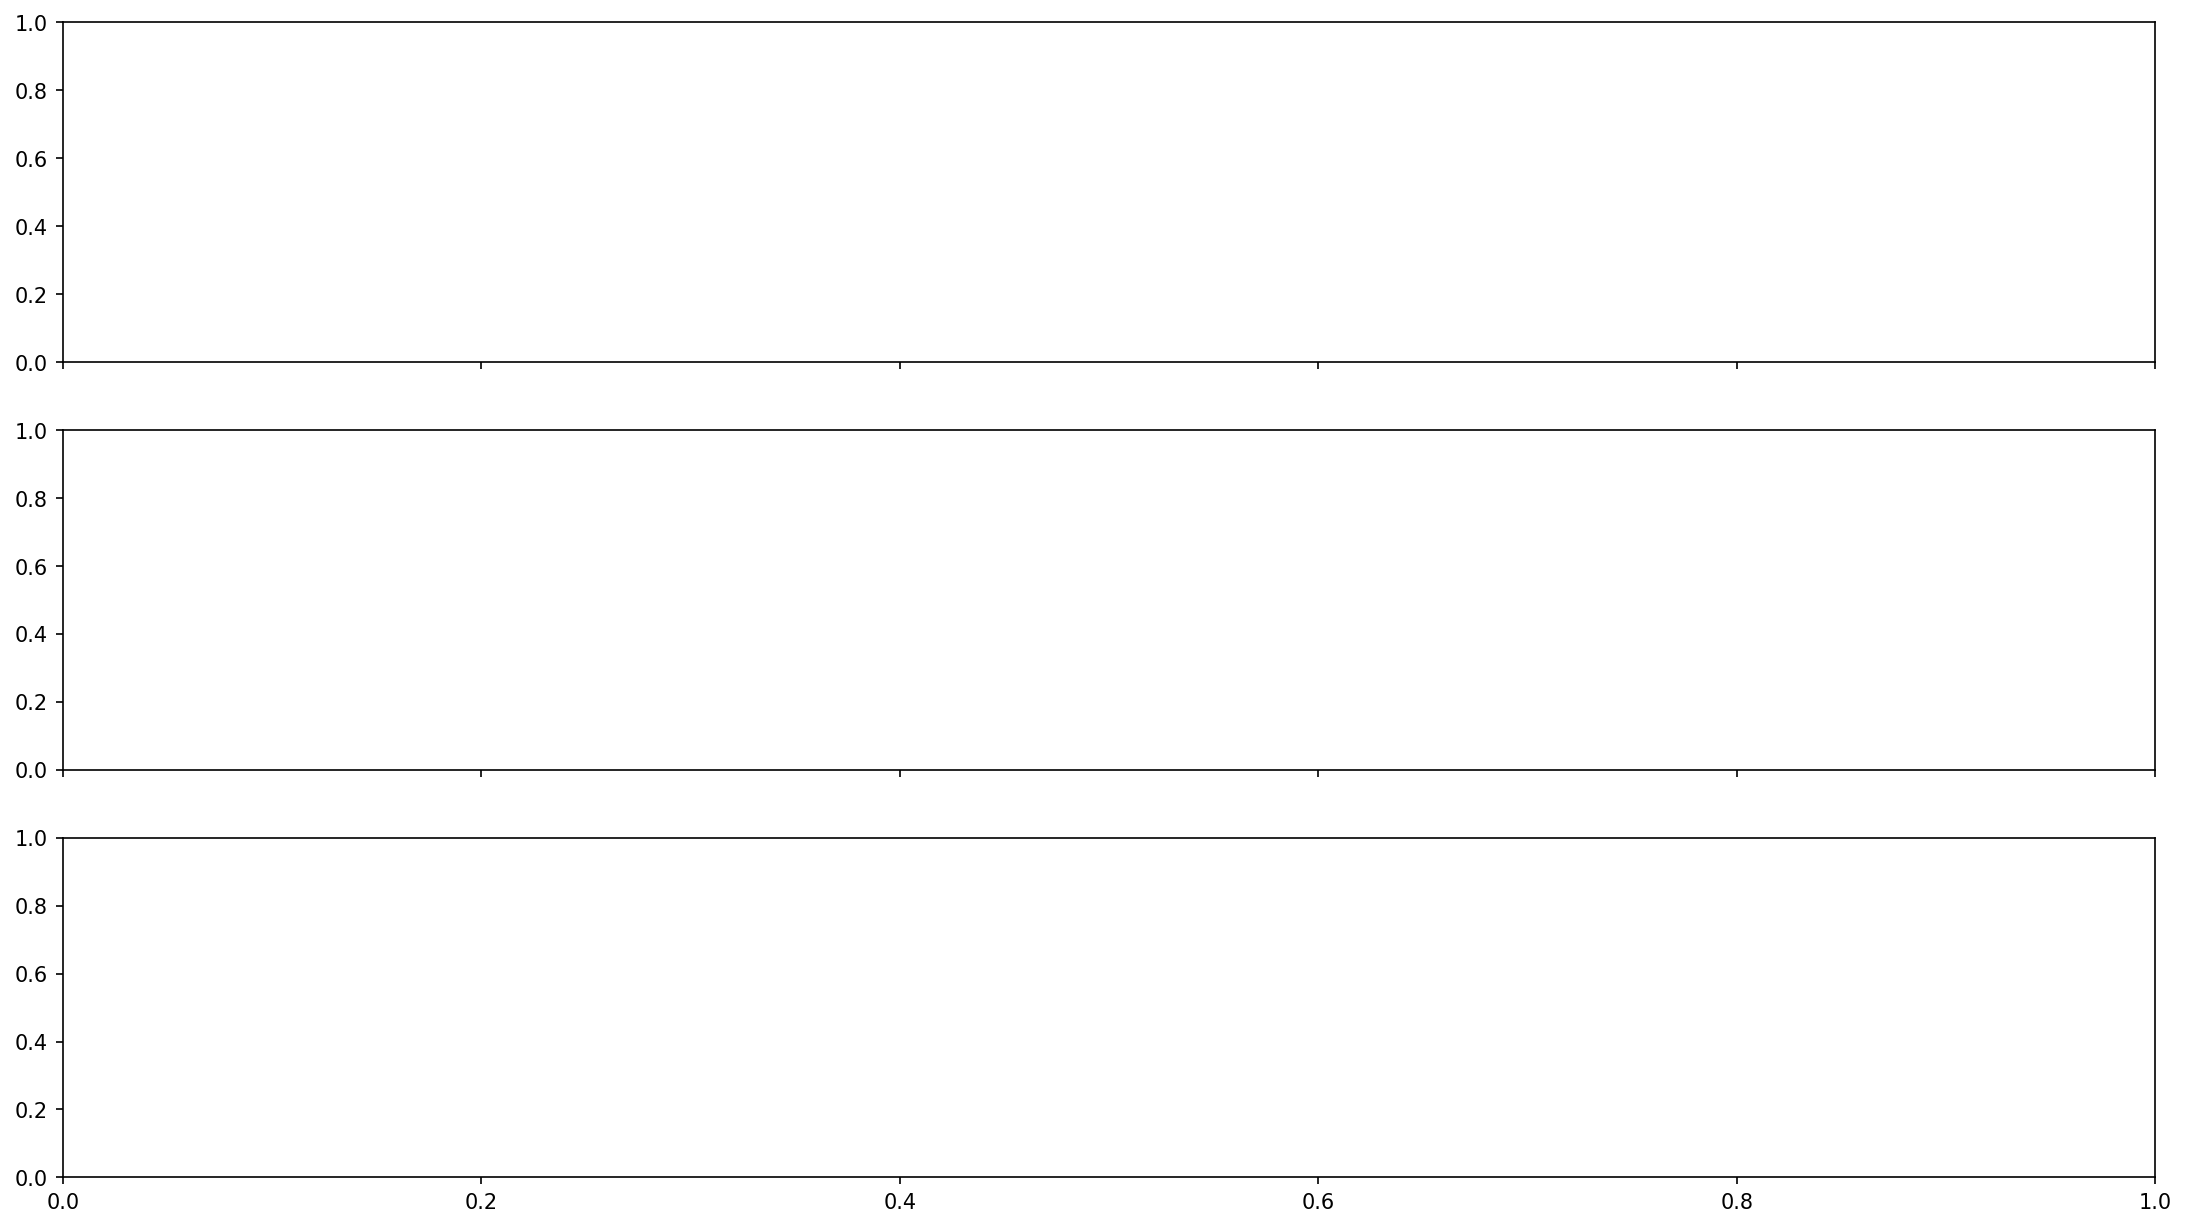

In [56]:
fig, axes = plt.subplots(
    3, 1,
    figsize=(18, 10),   # 전체 크기 고정
    dpi=150,
    sharex=True
)

lagrangian_spe_plus_list = [(-1*x) for x in lagrangian_spe_list]

# axes[0].plot(x, E, "^--", label = "energy")

axes[0].plot(y, spe, "o", label = "lagrangian_spe")
# axes[0].set_ylim(1, 1.1)
# axes[0].set_yscale('log')
axes[0].grid()
axes[0].legend()

axes[1].plot(y, SV, "o", label = "lagrangian_sv")
# axes[1].set_ylim(0, 0.1)
# axes[1].set_yscale('log')
axes[1].grid()
axes[1].legend()

axes[2].plot(y, L, 'o', label = "Hinge Loss Gap")
axes[2].grid()
axes[2].legend()

# plt.show()